In [1]:
# %load_ext tensorboard
# fmt: off
from Interpretability.ModelAugmentation import *
from Interpretability.InterpretabilityMethods import *
from SequentialLearning.Tasks.MNISTClassificationTask import MNISTClassificationTask as Task
from SequentialLearning.EWC_Methods.EWC_Methods import *

import os
import shutil
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
# fmt: on
print(tf.config.list_physical_devices('GPU'))

[]


In [8]:
MODEL_SAVE_PATH = "models/main_model"
LOAD_MODEL = True
TRAIN_MODEL = not LOAD_MODEL

task_labels = [3,4,5]
model_input_shape = Task.IMAGE_SIZE
epochs = 250
training_batches = 0
validation_batches = 0
batch_size = 32
ewc_method = EWC_Method.FISHER_MATRIX

# Model Training and Architecture

In [9]:
model: tf.keras.Model
if LOAD_MODEL and os.path.exists(MODEL_SAVE_PATH):
    # Try to load model directly, if one exists
    print("LOADING MODEL")
    model = tf.keras.models.load_model(MODEL_SAVE_PATH)  # type: ignore
else:
    # Otherwise, make an entire new model!
    print("CREATING MODEL")
    model_inputs = model_layer = tf.keras.Input(shape=model_input_shape)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_0")(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_1")(model_layer)
    model_layer = tf.keras.layers.BatchNormalization()(model_layer)
    model_layer = tf.keras.layers.MaxPool2D((2,2))(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_2")(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_3")(model_layer)
    model_layer = tf.keras.layers.BatchNormalization()(model_layer)
    model_layer = tf.keras.layers.MaxPool2D((2,2))(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_4")(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_5")(model_layer)
    model_layer = tf.keras.layers.BatchNormalization()(model_layer)
    # model_layer = tf.keras.layers.MaxPool2D((2,2))(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_6")(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_7")(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_9")(model_layer)
    model_layer = tf.keras.layers.BatchNormalization()(model_layer)
    model_layer = tf.keras.layers.Flatten()(model_layer)
    model_layer = tf.keras.layers.Dense(32, activation="relu")(model_layer)
    model_layer = tf.keras.layers.Dropout(0.2)(model_layer)
    model_layer = tf.keras.layers.Dense(32, activation="relu")(model_layer)
    model_layer = tf.keras.layers.Dropout(0.2)(model_layer)
    model_layer = tf.keras.layers.Dense(len(task_labels))(model_layer)
    model = tf.keras.Model(inputs=model_inputs, outputs=model_layer, name="base_model")
if len(task_labels) == 2:
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
else:
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.summary()

LOADING MODEL


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_0 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        36928 

In [10]:
training_image_augmentation = None
# training_image_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomZoom(
#             height_factor=(-0.05, -0.25),
#             width_factor=(-0.05, -0.25)),
#     tf.keras.layers.RandomRotation(0.05, "constant")
# ])

task = Task(
        name=f"Task 0",
        model=model,
        model_base_loss=loss_fn,
        task_labels=task_labels,
        training_batches = 0,
        validation_batches = 0,
        batch_size=batch_size,
        training_image_augmentation = training_image_augmentation
    )
ewc_term_creator = EWC_Term_Creator(ewc_method, model, [task])

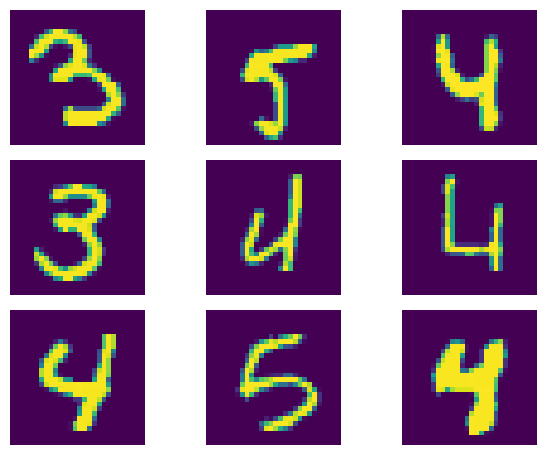

In [11]:
# Show some images from the task dataset
data = task.validation_dataset.take(1)
data_images, data_labels = data.as_numpy_iterator().next()
data_images = data_images[:9]
data_labels = data_labels[:9]
plot_images(data_images)

In [12]:
if TRAIN_MODEL:
    checkpoint_path = MODEL_SAVE_PATH+"/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=1)
    if os.path.isdir("./logs/TensorBoards"):
        shutil.rmtree("./logs/TensorBoards")
    history = task.train_on_task(epochs=epochs, callbacks=[
#         checkpoint_callback, 
        tf.keras.callbacks.TensorBoard(log_dir='./logs/TensorBoard'),
        *ewc_term_creator.callback_dict.values(),
    ])
    model.save(MODEL_SAVE_PATH)
else:
    print(f"{TRAIN_MODEL=}")
ewc_term = ewc_term_creator.create_term(ewc_lambda = 1)

TRAIN_MODEL=False
--------------------------------------------------------------------------------
STARTING FISHER CALCULATION
FINISHED FISHER CALCULATION
--------------------------------------------------------------------------------


In [39]:
ewc_term.omega_matrix[1][0][:,:,:,60]

<tf.Tensor: shape=(3, 3, 1), dtype=float32, numpy=
array([[[4775.577 ],
        [5167.629 ],
        [4490.657 ]],

       [[5137.6875],
        [5763.589 ],
        [5426.192 ]],

       [[3421.02  ],
        [4715.8184],
        [5833.7026]]], dtype=float32)>

In [8]:
threshold_model = threshold_model_by_omega(task.model, ewc_term.omega_matrix, 
    threshold_percentage = 0.2,
    comparison_method = ComparisonMethod.LAYER_WISE,
    aggregation_level = AggregationLevel.NO_AGGREGATION,
    aggregation_method = AggregationMethod.MEAN_AVERAGE,
)

LAYER_WISE layer_index=1 conv2d_0 threshold_value=0.018877445
LAYER_WISE layer_index=2 conv2d_1 threshold_value=0.0
LAYER_WISE layer_index=3 batch_normalization_1 threshold_value=0.0
LAYER_WISE layer_index=5 conv2d_2 threshold_value=0.1600953
LAYER_WISE layer_index=6 conv2d_3 threshold_value=237.1105
LAYER_WISE layer_index=7 batch_normalization_2 threshold_value=0.0
LAYER_WISE layer_index=9 conv2d_4 threshold_value=795.25275
LAYER_WISE layer_index=10 conv2d_5 threshold_value=1381.6207
LAYER_WISE layer_index=11 batch_normalization_3 threshold_value=0.0
LAYER_WISE layer_index=12 conv2d_6 threshold_value=2172.0374
LAYER_WISE layer_index=13 conv2d_7 threshold_value=688.027
LAYER_WISE layer_index=14 conv2d_9 threshold_value=0.5856285
LAYER_WISE layer_index=15 batch_normalization_4 threshold_value=0.0
LAYER_WISE layer_index=17 dense threshold_value=0.9035155
LAYER_WISE layer_index=19 dense_1 threshold_value=1.417956
LAYER_WISE layer_index=21 dense_2 threshold_value=57.593525


## Validation Testing

In [9]:
print(f"ORIGINAL  MODEL: {task.model.evaluate(task.validation_dataset, steps=task.validation_batches, return_dict=True)}")
print(f"THRESHOLD MODEL: {threshold_model.evaluate(task.validation_dataset, steps=task.validation_batches, return_dict=True)}")

100/100 [==============================] - 3s 7ms/step - loss: 4.9210 - base_loss: 4.9210
ORIGINAL  MODEL: {'loss': 4.921047210693359, 'base_loss': 4.921047210693359}
100/100 [==============================] - 2s 7ms/step - loss: nan
THRESHOLD MODEL: {'loss': nan}


# Interpretability Methods

## Kernel Inspection

OPERATING ON conv2d_1


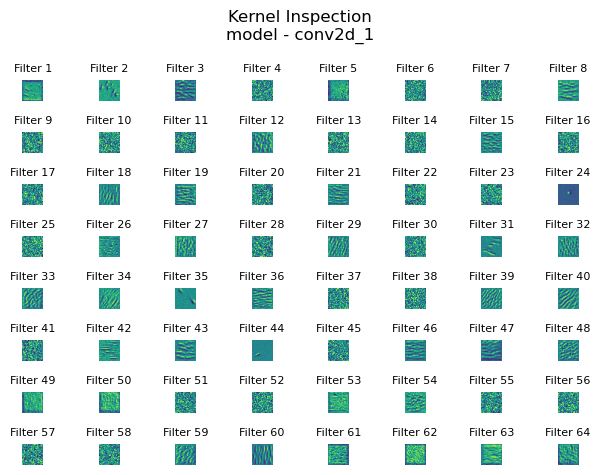

In [25]:
kernel_inspection(model=task.model, steps=50, step_size=0.01, layer_name="conv2d_1")
# kernel_inspection(model=task.model, steps=100, step_size=0.05, layer_name="conv2d_2")
# kernel_inspection(model=task.model, steps=100, step_size=0.01, layer_name="conv2d_9")

In [ ]:
kernel_inspection(model=threshold_model, steps=500, step_size=0.05, layer_name="conv2d_1")
# kernel_inspection(model=threshold_model, steps=100, step_size=0.05, layer_name="conv2d_2")
# kernel_inspection(model=threshold_model, steps=100, step_size=0.05, layer_name="conv2d_3")

## Occlusion Sensitivity

In [ ]:
occlusion_sensitivity(task.model, data_images, data_labels, patch_size=2, stride=1, occlusion_batch_size=128)

In [ ]:
occlusion_sensitivity(threshold_model, data_images, data_labels, patch_size=2, stride=1)

## GRADCAM

In [ ]:
ALPHA = 0.6
BETA = 1-ALPHA

GRADCAM(task.model, data_images, data_labels, layer_name="conv2d_6",
    alpha=ALPHA, beta=BETA,
    show_predictions=2, absolute_scale=None)

In [ ]:
GRADCAM(threshold_model, data_images, data_labels, layer_name="conv2d_3", 
    alpha=ALPHA, beta=BETA,
    show_predictions=0, absolute_scale=0.26)